In [1]:
%pip install bertopic pandas numpy matplotlib seaborn umap-learn

Note: you may need to restart the kernel to use updated packages.


c:\Users\Kanchan\Desktop\SciReX\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded 200 papers
Number of documents with non-null abstracts: 200
Using 200 valid abstracts for topic modeling
Setting up BERTopic model...


2025-04-19 23:37:58,514 - BERTopic - Embedding - Transforming documents to embeddings.


Using min_cluster_size: 10
Fitting BERTopic model to papers...


Batches: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]
2025-04-19 23:38:02,579 - BERTopic - Embedding - Completed ✓
2025-04-19 23:38:02,579 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-19 23:38:09,526 - BERTopic - Dimensionality - Completed ✓
2025-04-19 23:38:09,526 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-19 23:38:09,544 - BERTopic - Cluster - Completed ✓
2025-04-19 23:38:09,546 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-19 23:38:09,597 - BERTopic - Representation - Completed ✓
2025-04-19 23:38:09,643 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


Discovered 4 topics

Top discovered research topics:
Topic 0: 0_reasoning_llms_llm_agent (Count: 44)
Topic 1: 1_video_object_image_depth (Count: 31)
Topic 2: 2_retrieval_language_llms_rag (Count: 24)
Topic 3: 3_diffusion_diffusion models_latent_representation (Count: 12)
BERTopic model saved to models/bertopic_model
Topic visualization saved to data/visualizations/topic_visualization.html
Error creating distribution visualization: This visualization cannot be used if you have set `calculate_probabilities` to False as it uses the topic probabilities of all topics. 

Performing research gap analysis...
Research gap visualization saved to data/visualizations/research_gaps.png

Research gap analysis results:
interpretability: 0.00% coverage - HIGH GAP
ethics: 0.00% coverage - HIGH GAP
efficiency: 0.00% coverage - HIGH GAP
multimodal: 0.00% coverage - HIGH GAP
knowledge_graphs: 0.00% coverage - HIGH GAP
uncertainty: 0.00% coverage - HIGH GAP
few_shot: 0.00% coverage - HIGH GAP
robustness: 0

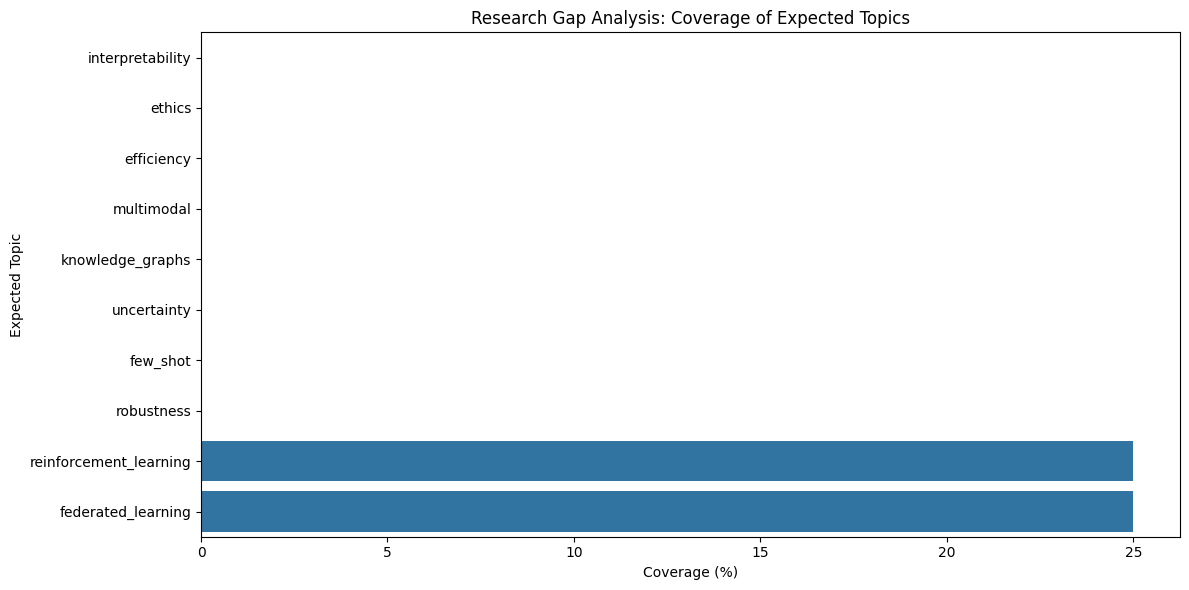

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
import os
import warnings
warnings.filterwarnings('ignore')

# Create necessary directories
os.makedirs("models", exist_ok=True)
os.makedirs("data/visualizations", exist_ok=True)
os.makedirs("data/results", exist_ok=True)
os.makedirs("data/cleaned", exist_ok=True)

# Load the enriched paper data
papers_df = pd.read_csv(r'C:\Users\Kanchan\Desktop\SciReX\data\cleaned\generative_ai_papers_enriched.csv')
print(f"Loaded {len(papers_df)} papers")

# Check the data
print(f"Number of documents with non-null abstracts: {papers_df['cleaned_abstract'].notna().sum()}")

# Prepare for topic modeling - only use valid abstracts
abstracts = papers_df['cleaned_abstract'].dropna().tolist()
print(f"Using {len(abstracts)} valid abstracts for topic modeling")

# Ensure we have enough documents
if len(abstracts) < 20:
    raise ValueError("Not enough documents for topic modeling. Need at least 20 valid abstracts.")

print("Setting up BERTopic model...")
# Initialize sentence transformer for embeddings
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

# Set up UMAP for dimensionality reduction
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

# Set up clustering model - adjust min_cluster_size based on dataset size
min_cluster_size = min(10, max(5, int(len(abstracts) * 0.05)))  # Dynamic sizing
print(f"Using min_cluster_size: {min_cluster_size}")

hdbscan_model = HDBSCAN(
    min_cluster_size=min_cluster_size,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# Set up vectorizer for topic representation - FIXED PARAMETERS
# Using less restrictive parameters to avoid conflicts
vectorizer_model = CountVectorizer(
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,       # Reduced from 5
    max_df=0.95,    # Increased from 0.7
)

# Create BERTopic model
topic_model = BERTopic(
    embedding_model=sentence_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    verbose=True
)

print("Fitting BERTopic model to papers...")
try:
    # Fit model to abstracts
    topics, probs = topic_model.fit_transform(abstracts)
    
    # Get topic information
    topic_info = topic_model.get_topic_info()
    num_topics = len(topic_info[topic_info['Topic'] != -1])
    print(f"Discovered {num_topics} topics")  # Exclude outlier topic (-1)
    
    # Print top topics
    print("\nTop discovered research topics:")
    for index, row in topic_info.head(10).iterrows():
        if row['Topic'] != -1:  # Skip outlier topic
            print(f"Topic {row['Topic']}: {row['Name']} (Count: {row['Count']})")
    
    # Save topic model
    topic_model.save("models/bertopic_model")
    print("BERTopic model saved to models/bertopic_model")
    
    # Add topic assignments to dataframe
    # Create a mapping from cleaned_abstract to topic
    abstract_to_topic = dict(zip(abstracts, topics))
    
    # Apply the mapping to the original dataframe
    papers_df['topic'] = papers_df['cleaned_abstract'].map(abstract_to_topic)
    papers_df.to_csv('data/cleaned/papers_with_topics.csv', index=False)
    
    # Create topic visualization
    try:
        fig = topic_model.visualize_topics()
        fig.write_html("data/visualizations/topic_visualization.html")
        print("Topic visualization saved to data/visualizations/topic_visualization.html")
    except Exception as e:
        print(f"Error creating topic visualization: {e}")
    
    # Create document-topic distribution visualization for the first document
    if len(probs) > 0:
        try:
            fig = topic_model.visualize_distribution(probs[0], min_probability=0.01)
            fig.write_html("data/visualizations/document_topic_distribution.html")
            print("Document-topic distribution saved to data/visualizations/document_topic_distribution.html")
        except Exception as e:
            print(f"Error creating distribution visualization: {e}")
    
    # Research Gap Analysis
    print("\nPerforming research gap analysis...")
    
    # Expected topics in generative AI research (defined by domain experts)
    expected_topics = {
        'interpretability': ['interpret', 'explain', 'explainable', 'xai', 'transparency'],
        'ethics': ['ethic', 'bias', 'fair', 'responsible', 'alignment'],
        'efficiency': ['efficient', 'compress', 'distill', 'lightweight', 'quantization'],
        'multimodal': ['multimodal', 'multi-modal', 'vision-language', 'image-text', 'audio-visual'],
        'reinforcement_learning': ['reinforcement', 'rl', 'reward', 'policy', 'agent'],
        'knowledge_graphs': ['knowledge graph', 'kg', 'ontology', 'semantic web'],
        'uncertainty': ['uncertainty', 'calibration', 'confidence', 'probabilistic'],
        'federated_learning': ['federated', 'decentralized', 'distributed', 'privacy'],
        'few_shot': ['few-shot', 'zero-shot', 'prompt', 'in-context'],
        'robustness': ['robust', 'adversarial', 'defense', 'attack', 'security']
    }
    
    # Calculate coverage for each expected topic
    topic_words = {}
    for topic_id in topic_model.get_topics():
        if topic_id == -1:  # Skip outlier topic
            continue
        words = [word for word, _ in topic_model.get_topic(topic_id)]
        topic_words[topic_id] = words
    
    # Check coverage of expected topics
    topic_coverage = {}
    for expected_topic, keywords in expected_topics.items():
        coverage = 0
        for topic_id, words in topic_words.items():
            # Check if any keyword is in the topic words
            if any(keyword in ' '.join(words).lower() for keyword in keywords):
                coverage += 1
    
        # Calculate coverage percentage
        coverage_percentage = (coverage / len(topic_words)) * 100 if topic_words else 0
        topic_coverage[expected_topic] = coverage_percentage
    
    # Sort by coverage (ascending to highlight gaps)
    sorted_coverage = sorted(topic_coverage.items(), key=lambda x: x[1])
    
    # Visualize research gaps
    plt.figure(figsize=(12, 6))
    coverage_df = pd.DataFrame(sorted_coverage, columns=['Expected Topic', 'Coverage (%)'])
    sns.barplot(x='Coverage (%)', y='Expected Topic', data=coverage_df)
    plt.title('Research Gap Analysis: Coverage of Expected Topics')
    plt.tight_layout()
    plt.savefig('data/visualizations/research_gaps.png')
    print("Research gap visualization saved to data/visualizations/research_gaps.png")
    
    print("\nResearch gap analysis results:")
    for topic, coverage in sorted_coverage:
        gap_level = "HIGH GAP" if coverage < 30 else "MEDIUM GAP" if coverage < 60 else "COVERED"
        print(f"{topic}: {coverage:.2f}% coverage - {gap_level}")
    
    # Prioritize research gaps
    research_gaps = []
    for topic, coverage in sorted_coverage:
        if coverage < 50:  # Consider topics with less than 50% coverage as gaps
            impact_score = (100 - coverage) / 100  # Higher score for lower coverage
    
            # Additional impact factors (hypothetical, can be customized)
            topic_importance = {
                'interpretability': 0.9,
                'ethics': 0.95,
                'efficiency': 0.8,
                'multimodal': 0.85,
                'reinforcement_learning': 0.75,
                'knowledge_graphs': 0.7,
                'uncertainty': 0.8,
                'federated_learning': 0.7,
                'few_shot': 0.75,
                'robustness': 0.9
            }
    
            importance = topic_importance.get(topic, 0.5)
            final_impact = impact_score * importance
    
            research_gaps.append({
                'topic': topic,
                'coverage': coverage,
                'impact_score': final_impact,
                'priority': 'HIGH' if final_impact > 0.7 else 'MEDIUM' if final_impact > 0.4 else 'LOW'
            })
    
    # Sort gaps by impact score
    research_gaps = sorted(research_gaps, key=lambda x: x['impact_score'], reverse=True)
    
    # Save prioritized research gaps
    gaps_df = pd.DataFrame(research_gaps)
    gaps_df.to_csv('data/results/research_gaps.csv', index=False)
    print("\nPrioritized research gaps saved to data/results/research_gaps.csv")
    
    print("\nTop research gaps to address:")
    for i, gap in enumerate(research_gaps[:5]):
        print(f"{i+1}. {gap['topic']} (Priority: {gap['priority']}, Impact Score: {gap['impact_score']:.2f})")

except ValueError as e:
    print(f"Error in BERTopic processing: {e}")
    
    # Try with even more relaxed parameters if first attempt fails
    if "max_df corresponds to < documents than min_df" in str(e):
        print("\nRetrying with more relaxed parameters...")
        
        # Create a new vectorizer with extremely relaxed parameters
        vectorizer_model = CountVectorizer(
            stop_words='english',
            ngram_range=(1, 1),  # Only unigrams
            min_df=1,            # Accept terms appearing in just 1 document
            max_df=1.0           # Accept terms appearing in all documents
        )
        
        # Create a new model
        topic_model = BERTopic(
            embedding_model=sentence_model,
            umap_model=umap_model,
            hdbscan_model=hdbscan_model,
            vectorizer_model=vectorizer_model,
            verbose=True
        )
        
        try:
            # Try fitting again
            topics, probs = topic_model.fit_transform(abstracts)
            print("Successfully fit model with relaxed parameters")
            
            # Save results
            topic_info = topic_model.get_topic_info()
            print(f"Discovered {len(topic_info[topic_info['Topic'] != -1])} topics")
            topic_model.save("models/bertopic_model")
            
            # Basic output only
            print("\nTop discovered research topics:")
            for index, row in topic_info.head(10).iterrows():
                if row['Topic'] != -1:
                    print(f"Topic {row['Topic']}: {row['Name']} (Count: {row['Count']})")
                    
        except Exception as e2:
            print(f"Second attempt also failed: {e2}")
            print("Consider checking your dataset or using a different approach for topic modeling.")